# Setup

In [1]:
import sys
!{sys.executable} -m pip install numpy scipy wfdb matplotlib

In [2]:
import os
import configparser

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from scipy.io import savemat

import wfdb

from denoising import preprocess

In [3]:
config = configparser.ConfigParser()
config.read('../../config.ini')

['../../config.ini']

In [4]:
PROJECT_DIR = config.get('PATHS', 'PROJECT_PATH')
RAW_DATA_DIR = os.path.join(PROJECT_DIR, 'data/raw/bidmc-1.0.0')
FILTERED_DATA_DIR = os.path.join(PROJECT_DIR, 'data/filtered/mecg/bidmc-1.0.0')

os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(FILTERED_DATA_DIR, exist_ok=True)

SIZE = 53
SAMPLING_RATE = 125

In [5]:
def get_filenames_bidmc(data_dir : str = RAW_DATA_DIR) -> np.ndarray:
    x = []
    for patient_num in range(1, SIZE + 1):
        x.append(os.path.join(data_dir, f'bidmc{patient_num:02}'))
    data = np.array(x, dtype=str)
    return data

In [6]:
filenames = get_filenames_bidmc()

In [7]:
samp = wfdb.rdsamp(filenames[0])
print(samp)

(array([[0.35386212, 0.43597077, 0.52548278, 0.30393168, 0.72547721],
       [0.35679189, 0.43206423, 0.51960599, 0.33528915, 0.67059658],
       [0.35874508, 0.42815044, 0.51568813, 0.37452135, 0.60980856],
       ...,
       [0.14662618, 0.40175954, 0.49998609, 0.53529322, 0.38431744],
       [0.14174322, 0.40175954, 0.49998609, 0.53920701, 0.38039958],
       [0.13783685, 0.40273618, 0.4941093 , 0.53529322, 0.38039958]]), {'fs': 125, 'sig_len': 60001, 'n_sig': 5, 'base_date': None, 'base_time': None, 'units': ['pm', 'NU', 'mV', 'mV', 'mV'], 'sig_name': ['RESP,', 'PLETH,', 'V,', 'AVR,', 'II,'], 'comments': ['<age>: 88 <sex>: M <location>: micu <source>: https://physionet.org/physiobank/database/mimic2wdb/matched/s01182/ <data segment>: 2688-03-25-23-14<modifications>: this is not a verbatim copy of an original file. Please see the accompanying LICENSE.txt file for further details.']})


In [8]:
samp[0].shape

(60001, 5)

In [9]:
def load_ecg_bidmc(fname : str) -> np.ndarray:
    samp = wfdb.rdsamp(fname)
    return samp[0][:,samp[1]['sig_name'].index('II,')]

# Filtering Analysis

Preprocessing pipeline consists of an FIR filter to eliminate powerline noise and baseline drift followed by Savitsky Golay for smoothing and a wavelet filter. Each filtering step is tested and selected added in each of the following sections.

In [10]:
preprocess_params = {}

## FIR Filter

In [11]:
preprocess_params['winlen'] = 0
preprocess_params['polyorder'] = 0
preprocess_params['wavelet'] = ''
preprocess_params['lvl'] = 0

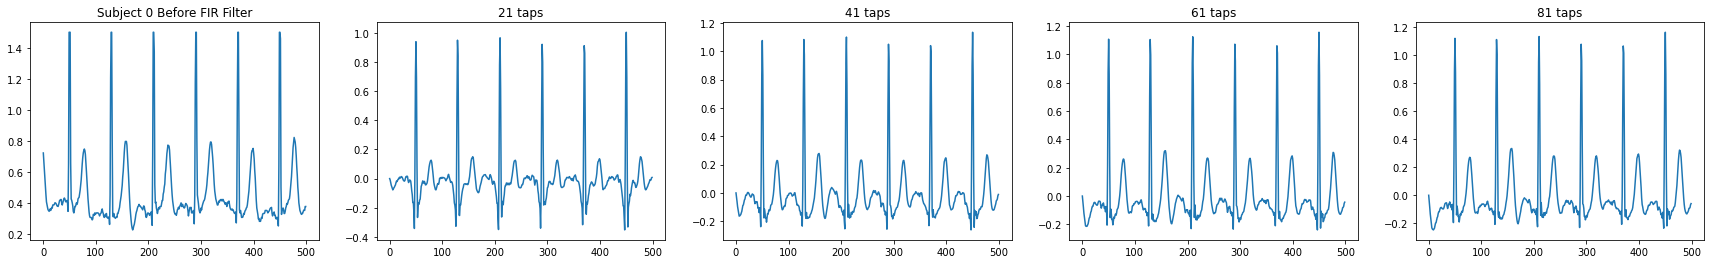

In [12]:
preprocess_params['numtaps'] = 0

shorten_factor = 50
subset_len = SIZE // shorten_factor

taps_delta = 20
taps_start = 21

for i in range(subset_len):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))
    ind = i * shorten_factor
    sig_window, _ = preprocess(load_ecg_bidmc(filenames[ind]), SAMPLING_RATE, **preprocess_params)
    
    axs[0].set_title(f'Subject {ind} Before FIR Filter')
    axs[0].plot(sig_window[:500])
    
    for j in range(1, 5):
        taps = taps_delta * (j - 1) + taps_start
        preprocessed_signal, _ = preprocess(sig_window, SAMPLING_RATE, numtaps=taps)
        axs[j].set_title(f'{taps} taps')
        axs[j].plot(preprocessed_signal[:500])

    plt.show()

In [13]:
preprocess_params['numtaps'] = 61

## Savitzky Golay Filter

In [14]:
preprocess_params['wavelet'] = ''
preprocess_params['lvl'] = 0

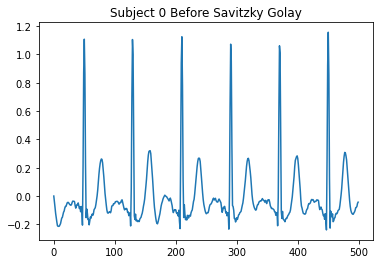

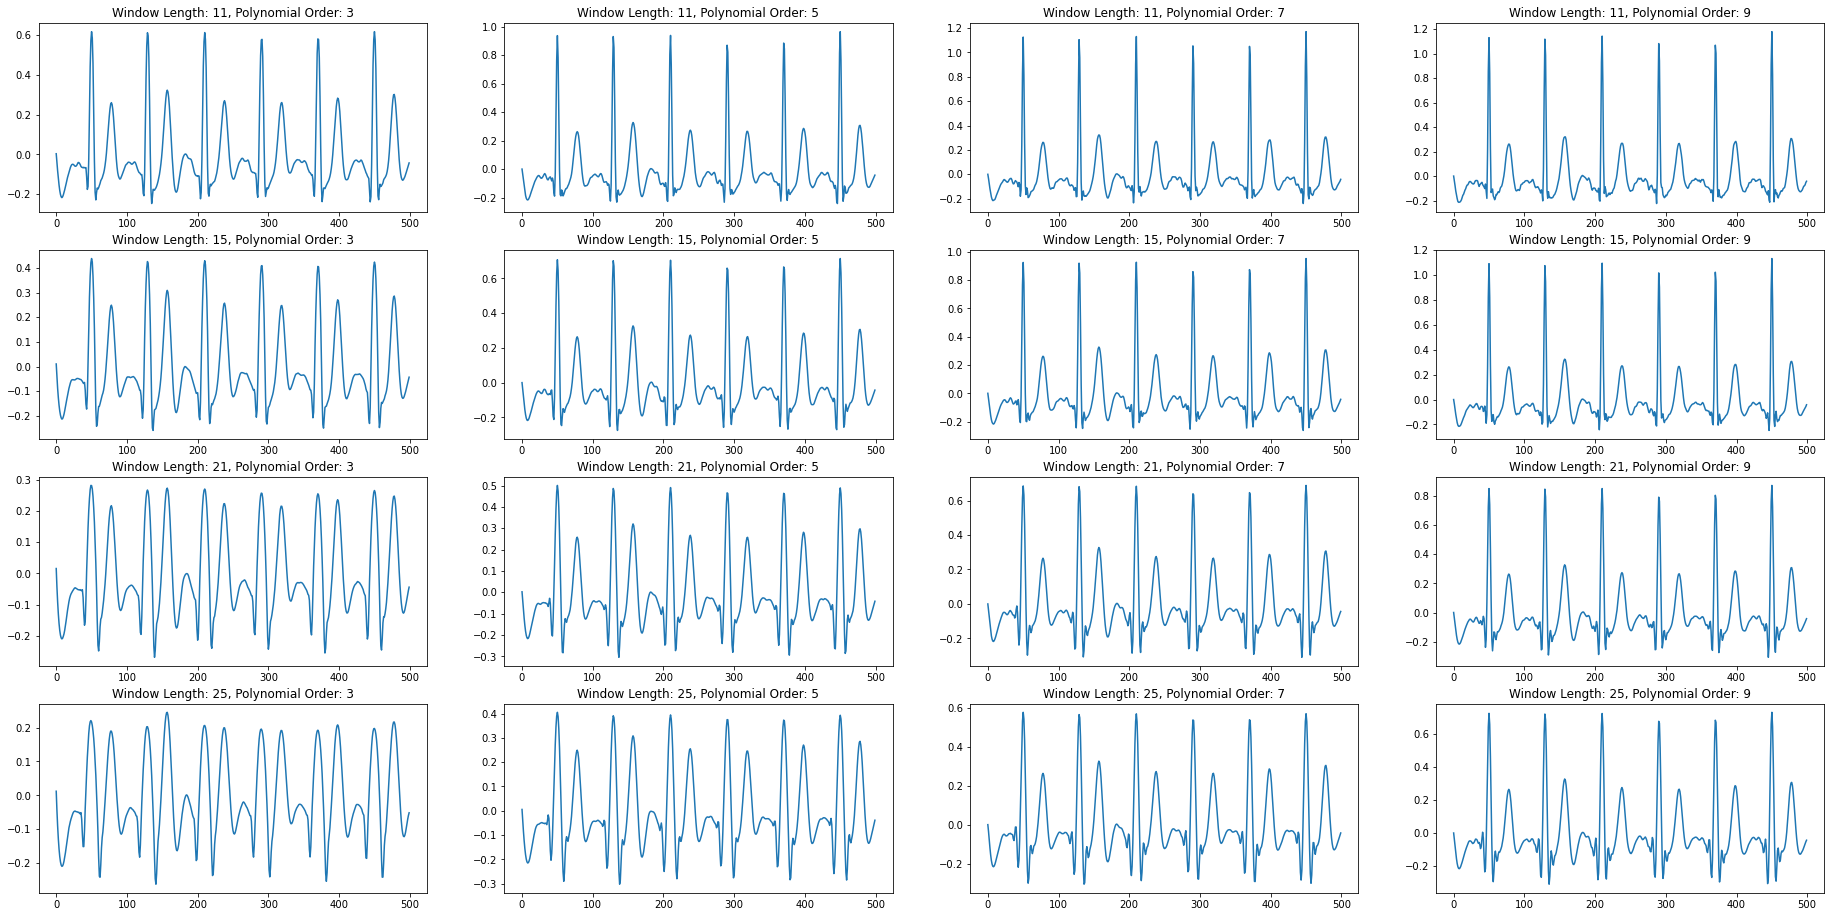

In [15]:
preprocess_params['winlen'] = 0
preprocess_params['polyorder'] = 0

shorten_factor = 50
subset_len = SIZE // shorten_factor

win_cand = (11, 15, 21, 25)
ord_cand = (3, 5, 7, 9)
win_cand_count = len(win_cand)
ord_cand_count = len(ord_cand)

for i in range(subset_len):
    ind = i * shorten_factor
    sig_window, _ = preprocess(load_ecg_bidmc(filenames[ind]), SAMPLING_RATE, **preprocess_params)
    
    plt.title(f'Subject {ind} Before Savitzky Golay')
    plt.plot(sig_window[:500])
    
    fig, axs = plt.subplots(nrows=win_cand_count, ncols=ord_cand_count, figsize=(8 * win_cand_count, 4 * ord_cand_count))
    for j in range(win_cand_count):
        for k in range(ord_cand_count):
            winlen = win_cand[j]
            polyorder = ord_cand[k]
            preprocessed_signal, _ = preprocess(sig_window, SAMPLING_RATE, winlen=winlen, polyorder=polyorder)
            axs[j][k].set_title(f'Window Length: {winlen}, Polynomial Order: {polyorder}')
            axs[j][k].plot(preprocessed_signal[:500])

    plt.show()

In [16]:
preprocess_params['winlen'] = 15
preprocess_params['polyorder'] = 5

## Wavelet Filter

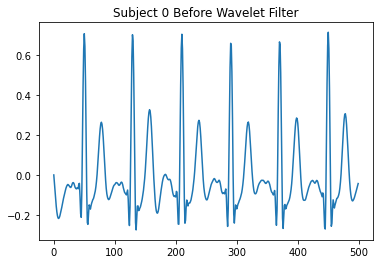

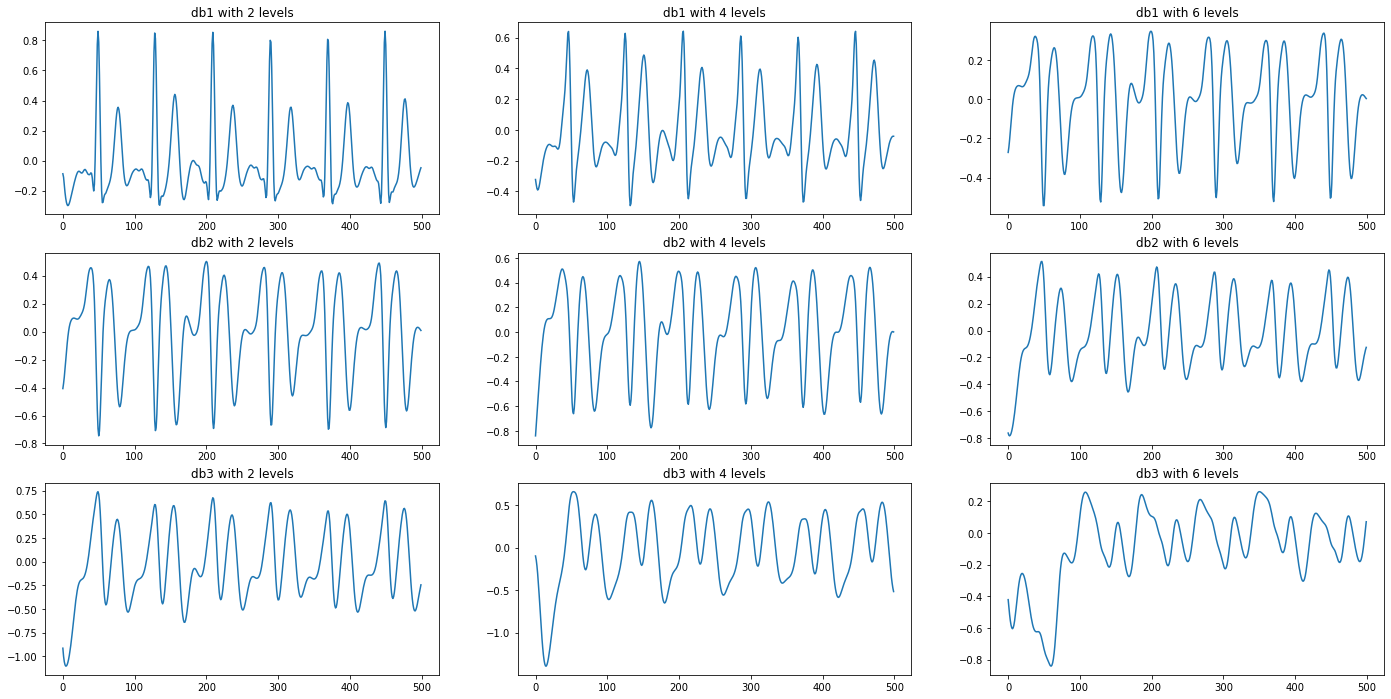

In [17]:
preprocess_params['wavelet'] = ''
preprocess_params['lvl'] = 0

shorten_factor = 50
subset_len = SIZE // shorten_factor

family = 'db'
wave_cand = (1, 2, 3)
wave_cand_count = len(wave_cand)
levels_cand = (2, 4, 6)
levels_cand_count = len(levels_cand)

for i in range(subset_len):
    ind = i * shorten_factor
    sig_window, _ = preprocess(load_ecg_bidmc(filenames[ind]), SAMPLING_RATE, **preprocess_params)
    
    plt.title(f'Subject {ind} Before Wavelet Filter')
    plt.plot(sig_window[:500])
    fig, axs = plt.subplots(nrows=wave_cand_count, ncols=levels_cand_count, figsize=(8 * levels_cand_count, 4 * wave_cand_count))
    for j in range(wave_cand_count):
        for k in range(levels_cand_count):
            wavelet = f'{family}{wave_cand[j]}'
            lvl = levels_cand[k]
            sig_window, _ = preprocess(sig_window, SAMPLING_RATE, wavelet=wavelet, lvl=lvl)
            axs[j][k].set_title(f'{wavelet} with {lvl} levels')
            axs[j][k].plot(sig_window[:500])

    plt.show()

In [18]:
preprocess_params['wavelet'] = 'db1'
preprocess_params['lvl'] = 2

# Filter All and Save

In [19]:
bad_subjects = set() # Maybe consider removing subjects 3, 33, and 53

In [20]:
def save_data_bidmc(filenames : np.ndarray, preprocess_params : dict, data_dir : str = FILTERED_DATA_DIR): 
    for fname in filenames:
        if i in bad_subjects:
            continue
        raw_sig = load_ecg_bidmc(fname)
        filt_sig, light_filt_sig = preprocess(raw_sig, SAMPLING_RATE, **preprocess_params)
        d = {'filtered' : filt_sig, 'light': light_filt_sig, 'raw' : raw_sig}
        savemat(file_name=os.path.join(FILTERED_DATA_DIR, os.path.basename(fname)), mdict=d)

In [21]:
save_data_bidmc(filenames, preprocess_params)